## The Battle of Neighborhoods | Finding a Better Place in North York, Toronto

# 1. Installing and Importing Python Libraries and Dependencies¶

In [1]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


# 2. Data Extraction and Cleaning

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'html.parser')



In [8]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [9]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [10]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [11]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,11,99
top,M4G,North York,Downsview
freq,1,24,4


In [12]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [13]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [14]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [15]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,11,99
top,M4G,North York,Downsview
freq,1,24,4


In [16]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [17]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M3H')

[43.75788000000006, -79.44846999999999]

In [21]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [19]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [20]:
df_2[df_2.Postalcode == 'M3H']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.75788,-79.44847


In [22]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of North York, Toronto are : {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of North York, Toronto are : 43.7543263, -79.44911696639593.



# 3. Map of Toronoto

In [23]:
map_NorthYork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

In [24]:
address = 'North York,Toronto'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood #1 are : {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood #1 are : 43.7543263, -79.44911696639593.


In [25]:
# @hiddel_cell
CLIENT_ID = '404YAURNUJCROHUQIR5VRFFZRVFXNJG4VXPF0FFNLKJ0KZCN' # my Foursquare ID
CLIENT_SECRET = '3BWEDVPCAYZGQFZ2KSOVVOCFIBCNKGUSYJQ01L1Y55FF0FD3' # my Foursquare Secret
VERSION = '20180605'
#LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 404YAURNUJCROHUQIR5VRFFZRVFXNJG4VXPF0FFNLKJ0KZCN
CLIENT_SECRET: 3BWEDVPCAYZGQFZ2KSOVVOCFIBCNKGUSYJQ01L1Y55FF0FD3


In [26]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [27]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# 4. Nearby Venues/Locations

In [28]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
3,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


# 5. Categories of Nearby Venues/Locations

In [29]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
4,Bagel Plus,Restaurant,43.755395,-79.440686


In [30]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  3
American Restaurant          1
Fried Chicken Joint          1
Coffee Shop                  1
Sushi Restaurant             1
Grocery Store                1
Middle Eastern Restaurant    1
Men's Store                  1
Mediterranean Restaurant     1
Bus Line                     1
Name: categories, dtype: int64

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
# Nearby Venues
NorthYork_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [33]:
print('There are {} Uniques Categories.'.format(len(NorthYork_venues['Venue Category'].unique())))
NorthYork_venues.groupby('Neighborhood').count().head()

There are 299 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,22,22,22,22,22,22
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",16,16,16,16,16,16
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25


# One Hot Encoding of Features

In [34]:
# one hot encoding
NorthYork_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NorthYork_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NorthYork_onehot.columns[-1]] + list(NorthYork_onehot.columns[:-1])
NorthYork_onehot = NorthYork_onehot[fixed_columns]
NorthYork_grouped = NorthYork_onehot.groupby('Neighborhood').mean().reset_index()
NorthYork_onehot.head(5)

,Zoo Exhibit,Accessories Store,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage 

In [35]:
num_top_venues = 5
for hood in NorthYork_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =NorthYork_grouped[NorthYork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0       Shopping Mall  0.09
1  Chinese Restaurant  0.09
2                Bank  0.05
3         Pizza Place  0.05
4    Sushi Restaurant  0.05


---- Alderwood, Long Branch ----
            venue  freq
0             Pub   0.1
1     Coffee Shop   0.1
2  Sandwich Place   0.1
3        Pharmacy   0.1
4             Gym   0.1


---- Bathurst Manor, Wilson Heights, Downsview North ----
                      venue  freq
0                      Park  0.12
1               Pizza Place  0.12
2               Coffee Shop  0.12
3               Men's Store  0.06
4  Mediterranean Restaurant  0.06


---- Bayview Village ----
              venue  freq
0           Dog Run  0.17
1  Asian Restaurant  0.17
2       Flower Shop  0.17
3              Park  0.17
4             Trail  0.17


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0      Sandwich Place  0.08
1         Coffee Shop  0.08
2  Italian Restaurant  0.08
3     Thai Restaurant  0.04

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Most Common venues near neighborhood¶

In [37]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthYork_grouped['Neighborhood']

for ind in np.arange(NorthYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthYork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Bank,Department Store,Sushi Restaurant,Sandwich Place,Supermarket,Discount Store,Latin American Restaurant,Bakery
1,"Alderwood, Long Branch",Pool,Gym,Gas Station,Sandwich Place,Convenience Store,Pizza Place,Coffee Shop,Pharmacy,Pub,Print Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Coffee Shop,Park,Men's Store,Restaurant,Mediterranean Restaurant,Sandwich Place,Deli / Bodega,Sushi Restaurant,Fried Chicken Joint
3,Bayview Village,Gas Station,Dog Run,Flower Shop,Park,Trail,Asian Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Sushi Restaurant,Juice Bar,Café,Butcher,Thai Restaurant,Japanese Restaurant,Intersection


# K-Means Clustering Approach

In [38]:
# Using K-Means to cluster neighborhood into 2 clusters
NorthYork_grouped_clustering = NorthYork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(NorthYork_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

In [39]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NorthYork_merged =df_2.iloc[17:35,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NorthYork_merged = NorthYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#NorthYork_merged.head(18)# check the last columns!
NorthYork_merged

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,M2H,North York,Hillcrest Village,43.80225,-79.35558,0,Park,Pharmacy,Residential Building (Apartment / Condo),Chinese Restaurant,Bakery,Fast Food Restaurant,Falafel Restaurant,Farm,Event Space,Ethiopian Restaurant
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.78097,-79.34781,1,Clothing Store,Fast Food Restaurant,Coffee Shop,Japanese Restaurant,Bakery,Women's Store,Restaurant,Juice Bar,Bank,Cosmetics Shop
19,M2K,North York,Bayview Village,43.78112,-79.38060,1,Gas Station,Dog Run,Flower Shop,Park,Trail,Asian Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant
20,M2L,North York,"York Mills, Silver Hills",43.75698,-79.38060,0,Park,Construction & Landscaping,Yoga Studio,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
21,M2M,North York,"Willowdale, Newtonbrook",43.79182,-79.41372,1,Korean Restaurant,Middle Eastern Restaurant,Coffee Shop,Café,Pizza Place,Indian Restaurant,Fried Chicken Joint,Sushi Restaurant,Supermarket,Bank
22,M2N,North York,"Willowdale, Willowdale East",43.76774,-79.40728,1,Coffee Shop,Pizza Place,Restaurant,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Sandwich Place,Bank,Fried Chicken Joint,Middle Eastern Restaurant
23,M2P,North York,York Mills West,43.74778,-79.40033,1,Restaurant,Park,Coffee Shop,Metro Station,Sandwich Place,Thai Restaurant,Food Court,Business Service,Japanese Restaurant,Deli / Bodega
24,M2R,North York,"Willowdale, Willowdale West",43.77989,-79.44678,1,Baby Store,Coffee Shop,Butcher,Park,Grocery Store,Pizza Place,Pharmacy,Discount Store,Event Space,Falafel Restaurant
25,M3A,North York,Parkwoods,43.75245,-79.32991,1,Pet Store,Park,Food & Drink Shop,Bus Stop,Burger Joint,Yoga Studio,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
26,M3B,North York,Don Mills,43.74923,-79.36186,1,Coffee Shop,Restaurant,Park,Science Museum,Café,Beer Store,Supermarket,Japanese Restaurant,Italian Restaurant,Bank


# Map of Clusters

In [40]:
kclusters = 10

# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NorthYork_merged['Latitude'], 
                                   NorthYork_merged['Longitude'], 
                                   NorthYork_merged['Neighborhood'], 
                                   NorthYork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [41]:
#cluster 1
df1=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 0,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df1

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Hillcrest Village,0,Park,Pharmacy,Residential Building (Apartment / Condo),Chinese Restaurant,Bakery,Fast Food Restaurant,Falafel Restaurant,Farm,Event Space,Ethiopian Restaurant
20,"York Mills, Silver Hills",0,Park,Construction & Landscaping,Yoga Studio,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room


In [42]:
#cluster2
df2=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 1,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df2

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",1,Clothing Store,Fast Food Restaurant,Coffee Shop,Japanese Restaurant,Bakery,Women's Store,Restaurant,Juice Bar,Bank,Cosmetics Shop
19,Bayview Village,1,Gas Station,Dog Run,Flower Shop,Park,Trail,Asian Restaurant,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant
21,"Willowdale, Newtonbrook",1,Korean Restaurant,Middle Eastern Restaurant,Coffee Shop,Café,Pizza Place,Indian Restaurant,Fried Chicken Joint,Sushi Restaurant,Supermarket,Bank
22,"Willowdale, Willowdale East",1,Coffee Shop,Pizza Place,Restaurant,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Sandwich Place,Bank,Fried Chicken Joint,Middle Eastern Restaurant
23,York Mills West,1,Restaurant,Park,Coffee Shop,Metro Station,Sandwich Place,Thai Restaurant,Food Court,Business Service,Japanese Restaurant,Deli / Bodega
24,"Willowdale, Willowdale West",1,Baby Store,Coffee Shop,Butcher,Park,Grocery Store,Pizza Place,Pharmacy,Discount Store,Event Space,Falafel Restaurant
25,Parkwoods,1,Pet Store,Park,Food & Drink Shop,Bus Stop,Burger Joint,Yoga Studio,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
26,Don Mills,1,Coffee Shop,Restaurant,Park,Science Museum,Café,Beer Store,Supermarket,Japanese Restaurant,Italian Restaurant,Bank
27,Don Mills,1,Coffee Shop,Restaurant,Park,Science Museum,Café,Beer Store,Supermarket,Japanese Restaurant,Italian Restaurant,Bank
28,"Bathurst Manor, Wilson Heights, Downsview North",1,Pizza Place,Coffee Shop,Park,Men's Store,Restaurant,Mediterranean Restaurant,Sandwich Place,Deli / Bodega,Sushi Restaurant,Fried Chicken Joint


In [43]:
NorthYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [44]:
NorthYork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

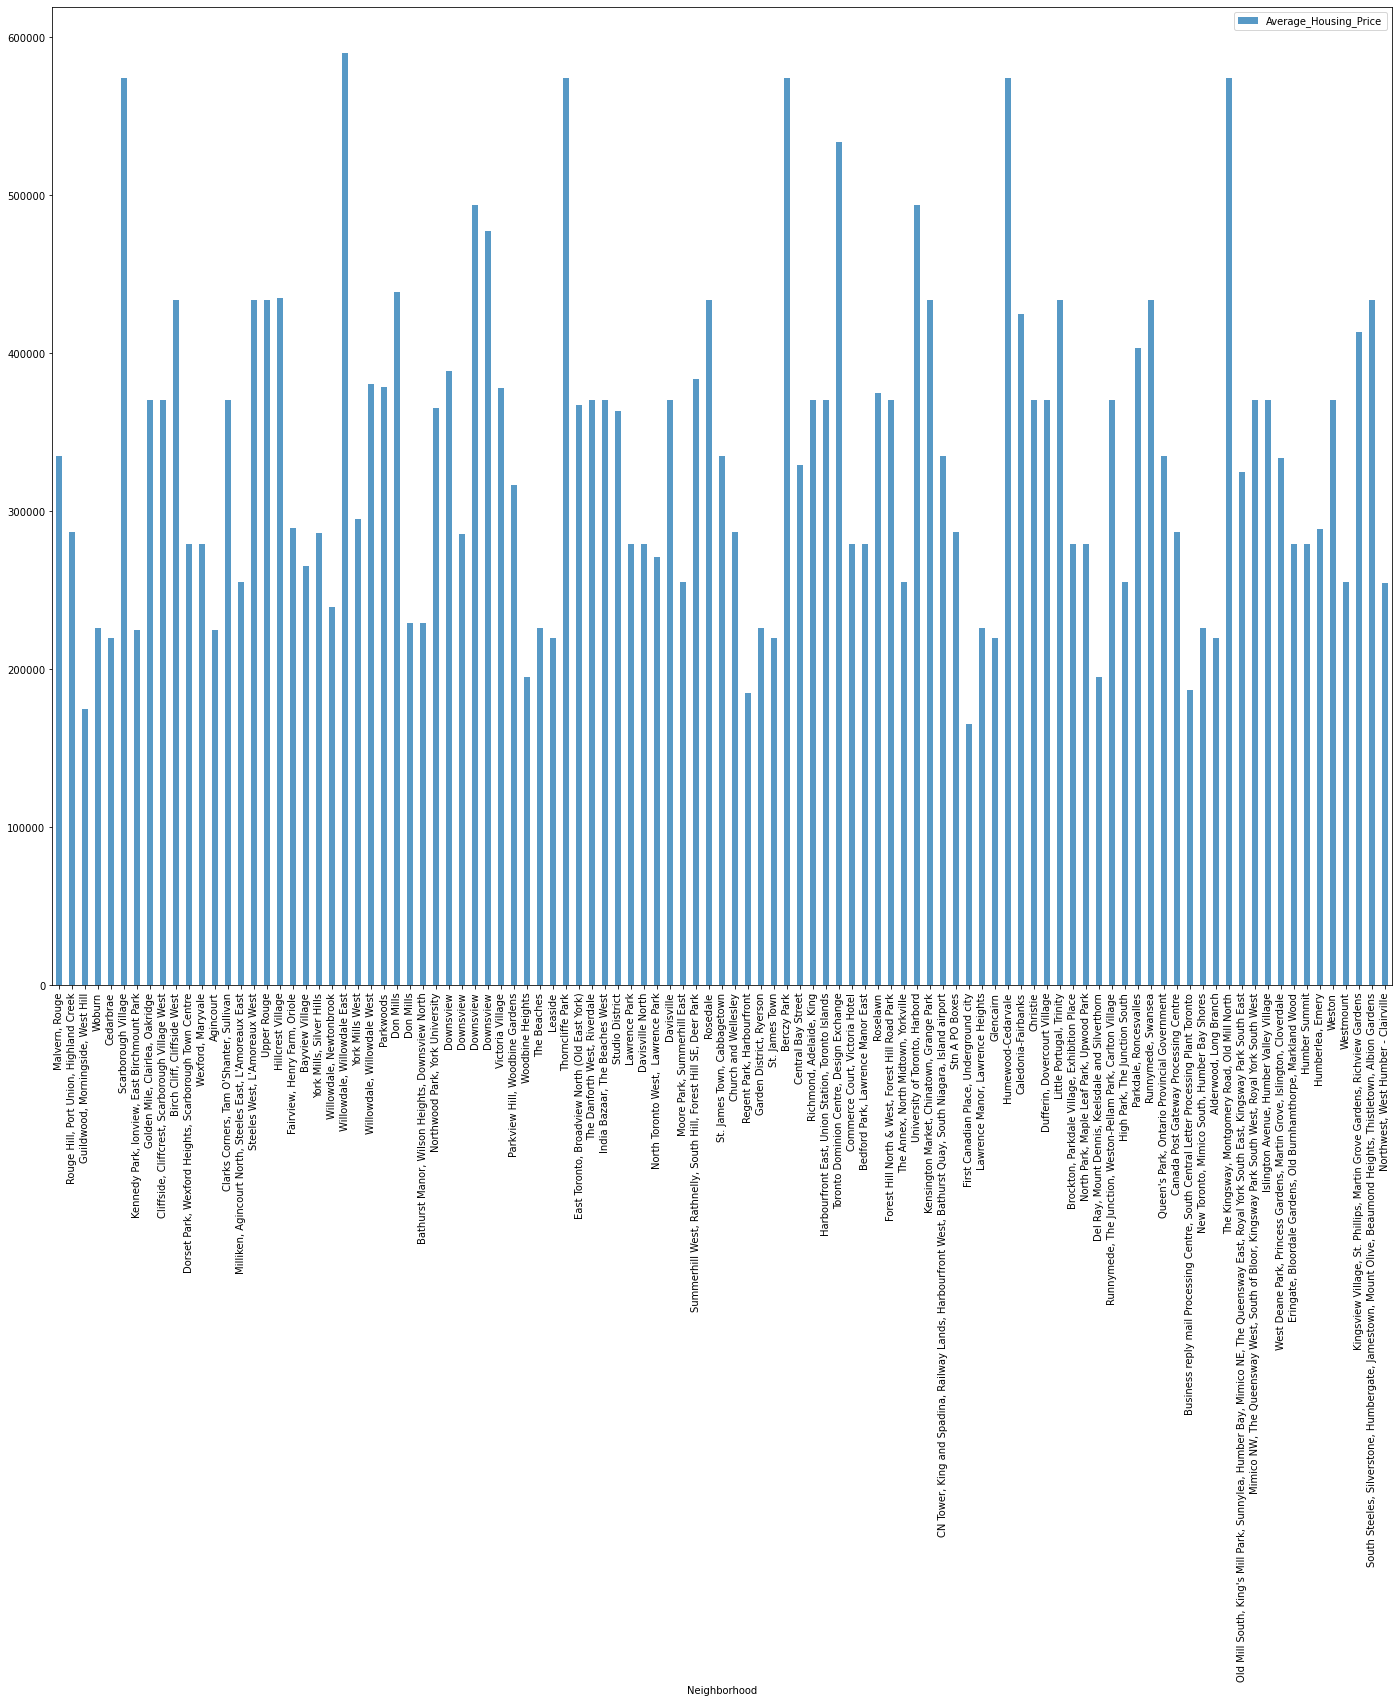

In [45]:
NorthYork_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

# School Rating by Clusters¶

In [46]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [47]:
new_NorthYork=NorthYork_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
NorthYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [48]:
NorthYork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

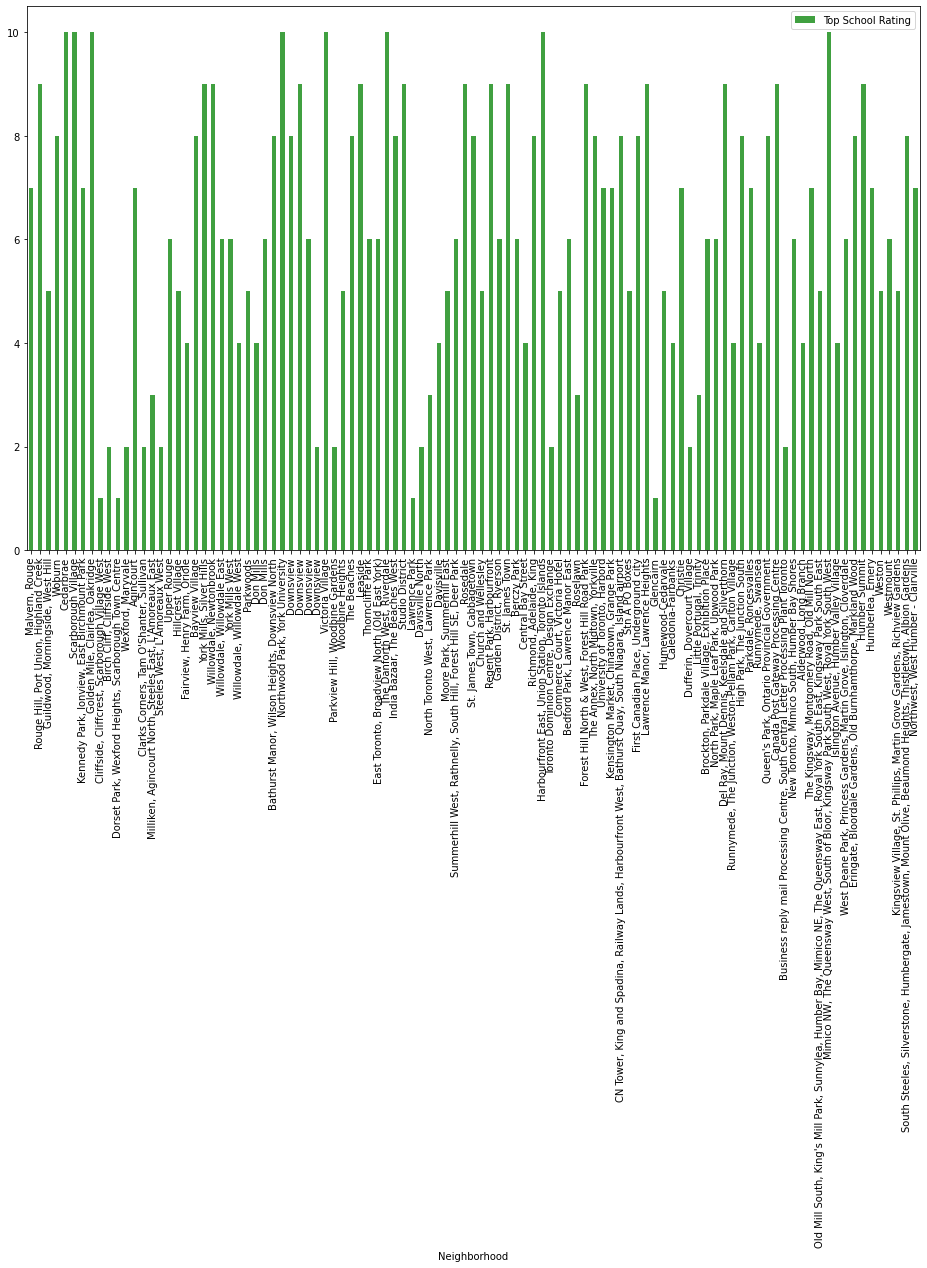

In [49]:
NorthYork_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.